<p style="text-align:center">
    <a href="https://www.ict.mahidol.ac.th/en/" target="_blank">
    <img src="https://www3.ict.mahidol.ac.th/ICTSurveysV2/Content/image/MUICT2.png" width="400" alt="Faculty of ICT">
    </a>
</p>

# Tutorial 12: Computer Vision with Pretrained Models

This tutorial provides a hands-on introduction to computer vision using pre-trained models.  It covers two key tasks: image classification (identifying the main object in an image) and object detection (locating and classifying multiple objects within an image).  Leveraging the power of transfer learning, we'll utilize pre-trained models (like EfficientNet or YOLOv8) to achieve high accuracy without extensive training.  Finally, the tutorial demonstrates how to deploy these computer vision models as interactive web applications using Streamlit, making them easily accessible and shareable.  No prior deep learning expertise is assumed.

### Download the dataset:
1. Download this lab's dataset from here: [LAB12-DATASETS](https://studentmahidolac-my.sharepoint.com/:u:/g/personal/suppawong_tua_mahidol_ac_th/ERH9Og_vxLRLnvuFTxgo8s0BYN7s4pN1tJxuvn8DQch3BA?e=CRwRsN)
2. Extract it under drive D: (to make sure there is no spaces in the path)

In [1]:
#Define the data path
#It is recommended that you extract "datasets" folder in D:/ to avoid having "white spaces" in the path
data_path = 'lab12_datasets'

## Exercise 01: Image Classification
This tutorial demonstrates image classification using EfficientNet (a pre-trained model) in PyTorch. We'll use a tiny "Cats vs. Dogs" dataset for simplicity.  Topics include model selection,preprocessing, feature extraction, fine-tuning, evaluation, and saving the model.

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image  # For checking image loading
import os
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

### 1. Dataset Loading and Preprocessing
We'll use a tiny "Cats vs. Dogs" dataset due to possible limitation of computational resources. The data should be organized into folders: train/cat, train/dog, val/cat, val/dog, test/cat, test/dog.

In [3]:
data_dir = data_path+'/cats_dogs_tiny' # Replace with your data directory

In [4]:
# Check if the data directory exists
if not os.path.exists(data_dir):
    print(f"Error: Data directory '{data_dir}' not found. Please download and organize the dataset.")
    exit() # Stop execution if the directory doesn't exist

In [5]:
# Define data transformations (important for pre-trained models)
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Resize and crop for EfficientNet
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

transform_val = transforms.Compose([ # Validation transforms (no random augmentations)
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

transform_test = transforms.Compose([ # Test transforms (no random augmentations)
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats
])

In [6]:
# Load the data using ImageFolder (easier with organized folders)
trainset = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'train'), transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

valset = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'val'), transform=transform_val)
valloader = torch.utils.data.DataLoader(valset, batch_size=32, shuffle=False, num_workers=2)

testset = torchvision.datasets.ImageFolder(root=os.path.join(data_dir, 'test'), transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

classes = trainset.classes # Get the class names directly from the dataset

### 2. Choosing a Pre-trained Model (EfficientNet)
We'll use EfficientNet-b0.  EfficientNet is known for its good performance and efficiency. Other options: ResNet, MobileNet (for mobile).  Consider accuracy vs. speed trade-offs.

In [7]:
model = torchvision.models.efficientnet_b0(pretrained=True)

c:\Users\gifly\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gifly\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 3. Modifying the Classifier (Fully Connected Layer)

In [8]:
# EfficientNet's classifier is designed for 1000 ImageNet classes. We need to change it.
num_features = model.classifier[1].in_features  # Access the correct layer for EfficientNet
model.classifier[1] = nn.Linear(num_features, len(classes))  # Replace with our classes

### 4. Training the Model (Fine-tuning)
**Warning**: This step will take a while (~5 minutes) if you run on CPU, even with a tiny training set.

In [9]:
#Check if CUDA is available
torch.cuda.is_available()

True

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam optimizer often works well

num_epochs = 5  # Adjust as needed

for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in valloader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Train Loss: {running_loss/len(trainloader)}, Val Loss: {val_loss/len(valloader)}, Val Accuracy: {100 * correct / total}%")

Epoch 1, Train Loss: 0.4891079877104078, Val Loss: 0.7831731326878071, Val Accuracy: 63.0%
Epoch 2, Train Loss: 0.1961349036012377, Val Loss: 1.0857402607798576, Val Accuracy: 60.0%
Epoch 3, Train Loss: 0.2057864995939391, Val Loss: 1.395768590271473, Val Accuracy: 65.0%
Epoch 4, Train Loss: 0.17082767401422774, Val Loss: 2.045985460281372, Val Accuracy: 62.0%
Epoch 5, Train Loss: 0.14268359076231718, Val Loss: 2.159271214157343, Val Accuracy: 63.0%


### 5. Model Evaluation (on the test set)

In [11]:
correct = 0
total = 0
y_true = []
y_pred = []

with torch.no_grad():
    for data in testloader:  # Iterate over the validation set
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

print(f"Accuracy of the model on the test images: {100 * correct / total}%")

cm = confusion_matrix(y_true, y_pred)
print("\nConfusion Matrix:")
print(cm)

cr = classification_report(y_true, y_pred, target_names=classes)
print("\nClassification Report:")
print(cr)


Accuracy of the model on the test images: 53.2%

Confusion Matrix:
[[251 249]
 [219 281]]

Classification Report:
              precision    recall  f1-score   support

        cats       0.53      0.50      0.52       500
        dogs       0.53      0.56      0.55       500

    accuracy                           0.53      1000
   macro avg       0.53      0.53      0.53      1000
weighted avg       0.53      0.53      0.53      1000



### 6. Saving the Model

In [12]:
torch.save(model.state_dict(), 'cats_dogs_model.pth')

### 7. To load the model (example):

In [13]:
model = torchvision.models.efficientnet_b0(pretrained=False)
num_features = model.classifier[1].in_features
model.classifier[1] = nn.Linear(num_features, len(classes))
model.load_state_dict(torch.load('cats_dogs_model.pth'))
model.eval()

c:\Users\gifly\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gifly\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

## Exercise 02: Object Detection
This exercise demonstrates object detection using YOLOv8 (a pre-trained model) in PyTorch. We'll use a small publicly available dataset for simplicity.  The focus is on *using* the model, not building it from scratch.

### 1. Install ultralytics (if you haven't already)

In [ ]:
# !pip install ultralytics

In [15]:
import torch
from ultralytics import YOLO
import cv2  # For image processing
import matplotlib.pyplot as plt  # For displaying images (optional)
import os

### 2. Load a Pre-trained YOLOv8 Model 
YOLOv8 offers different sizes (n, s, m, l, x).  'n' is the smallest and fastest, good for this tutorial. You can choose a larger size if you have more resources and need higher accuracy.

In [16]:
model = YOLO('yolov8n.pt')  # Load the small YOLOv8 model (pretrained)

### 3. Prepare a Tiny Dataset (Example: Fruits)

For this exercise, let's use a tiny dataset of images with fruits (e.g., apples, bananas). The images should be in a folder (e.g., 'data/fruits_tiny/images').  Annotations (bounding boxes and labels) should be in a corresponding folder (e.g., 'data/fruits_tiny/labels') in YOLO format (txt files).
```
Example directory structure:
fruits_tiny/
  images/
    apple1.jpg
    banana1.jpg
    ...
  labels/
    apple1.txt (contains bounding box coordinates and class label)
    banana1.txt
    ...
```

In [17]:
#data_dir = data_path+'/fruits_tiny/train'  # Replace with your dataset directory
sample_data_dir = data_path+'/fruits_tiny/sample'

In [18]:
# Check if the data directory exists
#if not os.path.exists(data_dir):
#    print(f"Error: Data directory '{data_dir}' not found. Please download and organize the dataset.")
#    exit() # Stop execution if the directory doesn't exist

#image_dir = os.path.join(data_dir, 'images')

if not os.path.exists(sample_data_dir):
    print(f"Error: Data directory '{sample_data_dir}' not found. Please download and organize the dataset.")
    exit() # Stop execution if the directory doesn't exist
    
sample_image_dir = os.path.join(sample_data_dir, 'images')

### 4. Perform Object Detection on a Single Image

In [19]:
image_path = os.path.join(sample_image_dir, '01_ Apple.jpg')  # Example image path
results = model(image_path)  # Run object detection


image 1/1 c:\Users\gifly\Desktop\DataScience\lab12_package\lab12_datasets\fruits_tiny\sample\images\01_ Apple.jpg: 384x640 7 apples, 44.6ms
Speed: 3.0ms preprocess, 44.6ms inference, 103.3ms postprocess per image at shape (1, 3, 384, 640)


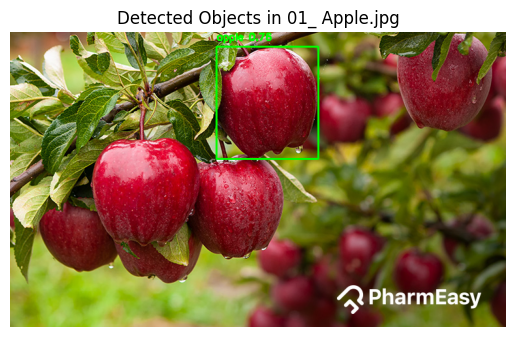

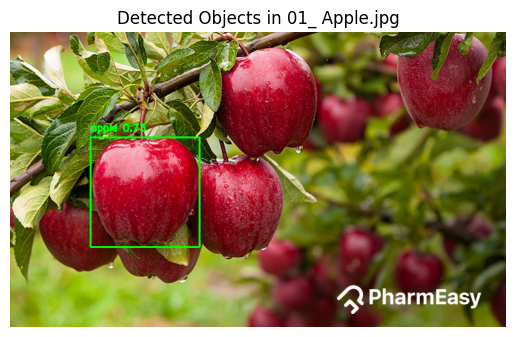

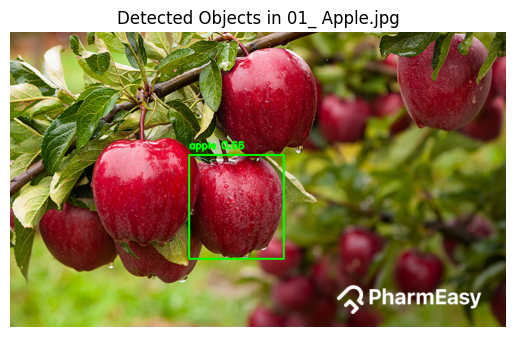

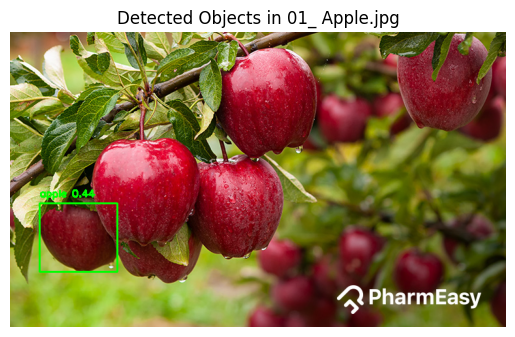

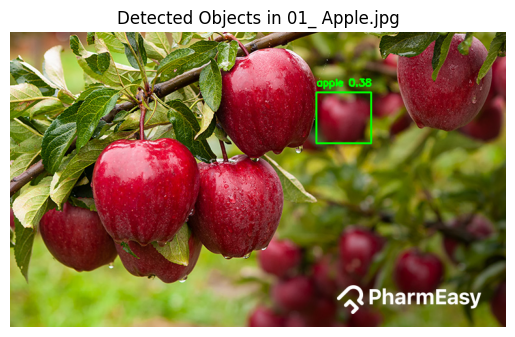

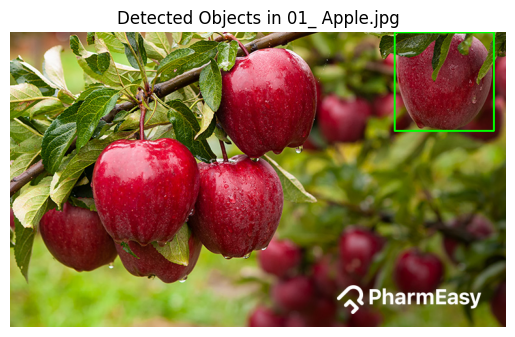

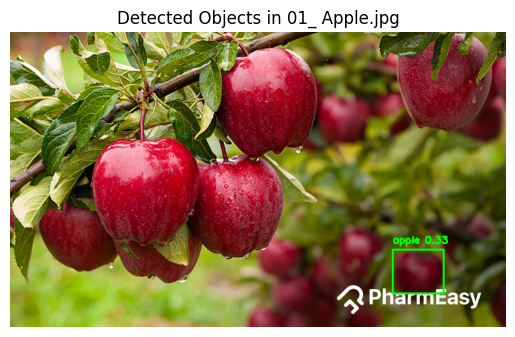

In [20]:
# Process the results
for result in results:  # Loop through detected objects
    boxes = result.boxes  # Bounding boxes object
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # Bounding box coordinates (top-left, bottom-right)
        cls = int(box.cls[0])  # Class ID
        conf = box.conf[0]  # Confidence score

        # Draw bounding box and label on the image (using OpenCV)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Correct color format for matplotlib
        cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2) # Green box
        cv2.putText(img, f'{result.names[cls]} {conf:.2f}', (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

        # (Optional) Display the image with bounding boxes using matplotlib
        plt.imshow(img)
        plt.title(f"Detected Objects in {os.path.basename(image_path)}")
        plt.axis('off')
        plt.show()

### # 5. Object Detection on a Batch of Images

In [21]:
# You can also perform object detection on a batch of images.

image_files = [os.path.join(sample_image_dir, f) for f in os.listdir(sample_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))] # Get all image files

results_batch = model(image_files) # Pass a list of images


0: 640x640 7 apples, 28.4ms
1: 640x640 1 surfboard, 2 bananas, 28.4ms
2: 640x640 2 apples, 2 oranges, 28.4ms
3: 640x640 4 apples, 1 cake, 1 dining table, 28.4ms
4: 640x640 2 apples, 28.4ms
5: 640x640 1 broccoli, 28.4ms
6: 640x640 (no detections), 28.4ms
7: 640x640 6 bananas, 28.4ms
8: 640x640 4 oranges, 28.4ms
9: 640x640 3 bananas, 11 apples, 3 oranges, 28.4ms
Speed: 3.8ms preprocess, 28.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


In [22]:
# # Process the results for each image in the batch (similar to the single image example)
# for i, result in enumerate(results_batch):
#     boxes = result.boxes  # Bounding boxes object
#     for box in boxes:
#         x1, y1, x2, y2 = box.xyxy[0]  # Bounding box coordinates (top-left, bottom-right)
#         cls = int(box.cls[0])  # Class ID
#         conf = box.conf[0]  # Confidence score

#         # Draw bounding box and label on the image (using OpenCV)
#         img = cv2.imread(image_files[i])
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Correct color format for matplotlib
#         cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2) # Green box
#         cv2.putText(img, f'{result.names[cls]} {conf:.2f}', (int(x1), int(y1)-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

#         # (Optional) Display the image with bounding boxes using matplotlib
#         plt.imshow(img)
#         plt.title(f"Detected Objects in {os.path.basename(image_files[i])}")
#         plt.axis('off')
#         plt.show()

*That is why you should fine-tune the model with your dataset if you can!* However, for this tutorial, we will simply use the pre-trained model without fine-tuning it.

### 6. Model Evaluation (on a validation set)
YOLOv8 provides built-in evaluation metrics.

In [95]:
# Assuming you have a validation set (e.g., 'fruits_data/val'), you can evaluate the model like this:
results_val = model.val(data=data_path+'/fruits_tiny/fruits_tiny.yaml') # Where fruits_data.yaml is your data configuration file

Ultralytics YOLOv8.2.103  Python-3.11.2 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce GTX 1660 Ti, 6144MiB)


100%|██████████| 755k/755k [00:01<00:00, 664kB/s]
val: Scanning C:\Users\gifly\Desktop\DataScience\lab12_package\lab12_datasets\fruits_tiny\val\labels... 87 images, 9 backgrounds, 0 corrupt: 100%|██████████| 96/96 [00:00<00:00, 575.99it/s]

val: New cache created: C:\Users\gifly\Desktop\DataScience\lab12_package\lab12_datasets\fruits_tiny\val\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:07<00:00,  1.32s/it]


                   all         96         88      0.106       0.17     0.0749     0.0428
                person         87         88      0.106       0.17     0.0749     0.0428
Speed: 2.6ms preprocess, 9.3ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs\detect\val83


### 7. Saving the Model

In [ ]:
# The model is already saved when you load it, but if you fine-tune it, you'll want to save the updated weights.
# model.save('fine_tuned_yolov8n.pt')

### 8. Exporting to ONNX (for Streamlit Deployment)
For deployment with Streamlit, exporting to ONNX format is often recommended.

In [96]:
success = model.export(format='onnx')  # Export the model to ONNX format

Ultralytics YOLOv8.2.103  Python-3.11.2 torch-2.6.0+cu126 CPU (Intel Core(TM) i7-9750H 2.60GHz)

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: Ultralytics requirement ['onnxslim==0.1.34'] not found, attempting AutoUpdate...

requirements: AutoUpdate success  3.8s, installed 1 package: ['onnxslim==0.1.34']
requirements:  Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.34...
ONNX: export success  5.4s, saved as 'yolov8n.onnx' (12.2 MB)

Export complete (5.7s)
Results saved to C:\Users\gifly\Desktop\DataScience\lab12_package
Predict:         yolo predict task=detect model=yolov8n.onnx imgsz=640  
Validate:        yolo val task=detect model=yolov8n.onnx imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


## Exercise 03 (Optional): Image Segmentation
This exercise demonstrates image segmentation using a pre-trained DeepLabv3 model in PyTorch. We'll use the PASCAL VOC 2012 dataset (or a subset) for demonstration.  We'll focus on *using* the model for inference, not training or fine-tuning it.

In [ ]:
import torch
import torchvision.transforms as T
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

### 1. Install Required Libraries (if you haven't already)

In [ ]:
!pip install torchvision segmentation-models-pytorch

### 2. Load the Pre-trained DeepLabv3 Model
We'll use a DeepLabv3 model pre-trained on the PASCAL VOC dataset.  Other options include U-Net, FCN, etc. Segmentation-models-pytorch is an excellent library for this.

In [ ]:
import segmentation_models_pytorch as smp

ENCODER = 'efficientnet-b7' # You can try other encoders like 'resnet50', 'efficientnet-b0', etc.
ENCODER_WEIGHTS = 'imagenet' # Or None if you want to train from scratch
CLASSES = 21 # Number of classes in PASCAL VOC (20 foreground + 1 background)

model = smp.DeepLabV3(
    encoder_name=ENCODER,
    encoder_weights=ENCODER_WEIGHTS,
    classes=CLASSES,
)

model.eval() # Set the model to evaluation mode (important for inference)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Use GPU if available
model.to(device)

### 3. Prepare the Image and Preprocessing

In [ ]:
# Load an image
image_path = data_path+'/seg_example/boat.jpg'  
if not os.path.exists(image_path):
    print(f"Error: Image path '{image_path}' not found.")
    exit()
    
img = Image.open(image_path).convert("RGB") # Open and convert to RGB

In [ ]:
# Define transformations (important for pre-trained models)
# These should match how the model was trained
transform = T.Compose([
    T.Resize([256,344]),  # Resize the image
    T.ToTensor(),  # Convert to tensor
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize using ImageNet stats
])

input_tensor = transform(img).unsqueeze(0)  # Add a batch dimension (models expect batches)
input_tensor = input_tensor.to(device) # Move tensor to device

### 4. Make Predictions (Inference)

In [ ]:
with torch.no_grad():  # Disable gradient calculations for inference
    output = model(input_tensor)

### 5. Post-processing and Visualization
The output is a tensor containing the segmentation mask (pixel-wise class predictions). Post-processing is usually needed to get a nice segmented image.

In [ ]:
# Get the predicted segmentation mask (the class with the highest probability for each pixel)
mask = torch.argmax(output, dim=1).squeeze().cpu().numpy() # Get the predicted mask

In [ ]:
# Convert the mask to a color image (optional, for better visualization)
# You'll need a colormap that maps class indices to colors.
# Here's a simple example for PASCAL VOC:
VOC_COLORMAP = np.array([[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                        [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                        [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                        [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                        [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                        [0, 64, 128]])

In [ ]:
segmented_image = VOC_COLORMAP[mask].astype(np.uint8) # Create the segmented image from the mask

In [ ]:
# Display the original and segmented images
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(segmented_image)
plt.title("Segmented Image")

plt.show()

### 6. Saving the Model
It's best practice to save only the model's state dictionary (the learned weights). This makes the saved file smaller and more portable.

In [ ]:
torch.save(model.state_dict(), 'deeplabv3_model.pth')

In [ ]:
# To load the model in Streamlit:
# model = smp.DeepLabv3(encoder_name=ENCODER, encoder_weights=None, classes=CLASSES) # Create model instance
# model.load_state_dict(torch.load('deeplabv3_model.pth')) # Load saved weights
# model.eval() # Set to evaluation mode

<p style="text-align:center;">That's it! Congratulations! <br> 
    Let's now work on your lab assigment.</p>